In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

In [118]:

# Генерация синтетических данных
num_nodes = 10  # Количество точек (клиентов и депо)
num_vehicles = 3  # Количество транспортных средств
num_features = 2  # Количество признаков для каждой точки (координаты)

# Создание случайных координат для точек
coordinates = torch.rand(num_nodes, num_features)

# Создание графа с ребрами, представляющими расстояния между точками
edge_index = torch.randint(0, num_nodes, (2, num_nodes * (num_nodes - 1) // 2))
edge_attr = torch.norm(coordinates[edge_index[0]] - coordinates[edge_index[1]], dim=1)

# Создание маски для разделения узлов на клиентов и депо
is_client = torch.randint(0, 2, (num_nodes,), dtype=torch.bool)

# Создание графового объекта PyTorch Geometric
data = Data(x=coordinates, edge_index=edge_index, edge_attr=edge_attr, is_client=is_client)

In [119]:
data

Data(x=[10, 2], edge_index=[2, 45], edge_attr=[45], is_client=[10])

In [120]:


# Определение Graph Attention Network (GAT) модели
class VRPGAT(nn.Module):
    def __init__(self, num_nodes, num_features, num_heads=1):
        super(VRPGAT, self).__init__()
        self.conv1 = GATConv(num_features, 10, heads=num_heads)
        self.conv2 = GATConv(10 * num_heads, 1, heads=num_heads)
        self.fc = nn.Linear(num_features, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x




In [121]:
model = VRPGAT(num_nodes=num_nodes, num_features=num_features, num_heads=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.L1Loss()



In [122]:
# Обучение модели
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output[data.is_client], torch.zeros_like(output[data.is_client]))
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

# Получение предсказанных маршрутов
predicted_routes = output.squeeze().detach().numpy()

Epoch [100/1000], Loss: 0.0043084025382995605
Epoch [200/1000], Loss: 0.008852556347846985
Epoch [300/1000], Loss: 0.0038350075483322144
Epoch [400/1000], Loss: 0.006041616201400757
Epoch [500/1000], Loss: 0.015496835112571716
Epoch [600/1000], Loss: 0.00852088164538145
Epoch [700/1000], Loss: 0.002264052629470825
Epoch [800/1000], Loss: 0.003381967544555664
Epoch [900/1000], Loss: 0.006845926400274038
Epoch [1000/1000], Loss: 0.007613832596689463


In [123]:
import torch

# output - предсказанные значения модели (ваша переменная)
# num_vehicles - количество транспортных средств

# Получите предсказанные маршруты для каждого клиента
predicted_routes = output.squeeze().detach().numpy()

# Инициализируйте список для хранения назначенных маршрутов
assigned_routes = []

# Назначьте каждому клиенту транспортное средство
for client_prediction in predicted_routes:
    client_prediction_tensor = torch.tensor(client_prediction)  # Преобразуйте в тензор
    assigned_vehicle = torch.argmax(client_prediction_tensor).item()
    assigned_routes.append(assigned_vehicle)

# assigned_routes содержит назначенные маршруты для каждого клиента
print(assigned_routes)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


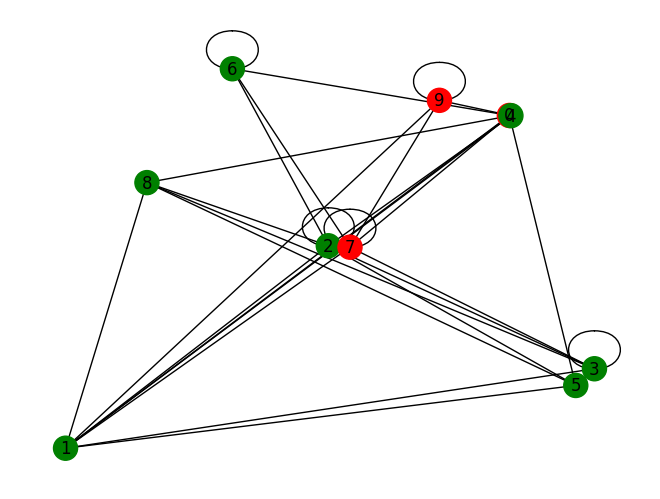

In [56]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = nx.Graph()

# Добавление узлов с координатами
for i in range(num_nodes):
    G.add_node(i, pos=coordinates[i].numpy())

# Добавление рёбер
for (i, j) in zip(edge_index[0], edge_index[1]):
    G.add_edge(i.item(), j.item())

# Создание графа маршрутов для каждого транспортного средства
route_colors = ['r', 'g', 'b']  # Цвета для каждого маршрута

# Создание цветов для каждой точки (клиентов и депо)
node_colors = ['g'] * num_nodes  # Изначально все точки красные (клиенты)
for i, route_idx in enumerate(data.is_client):
    if route_idx:
        node_colors[i] = route_colors[int(predicted_routes[i])]  # Присвоение цветов клиентам в соответствии с маршрутом

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=300)



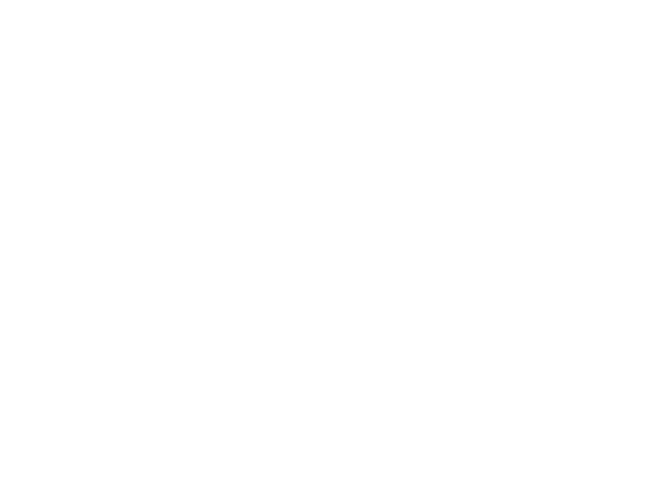

In [62]:
import matplotlib.pyplot as plt
import networkx as nx

# Выберите индекс транспортного средства, маршрут которого вы хотите визуализировать
selected_vehicle_index = 3  # Измените на нужный индекс

# Создайте граф только для выбранного маршрута
G = nx.Graph()
for i in range(num_nodes):
    G.add_node(i, pos=coordinates[i].numpy())

for (i, j) in zip(edge_index[0], edge_index[1]):
    G.add_edge(i.item(), j.item())

# Создайте список узлов, входящих в выбранный маршрут
selected_route_nodes = [i for i, route_idx in enumerate(data.is_client) if route_idx and predicted_routes[i] == selected_vehicle_index]

# Создайте граф только для выбранного маршрута
selected_route_G = G.subgraph(selected_route_nodes)

# Определите позиции узлов для визуализации
pos = nx.get_node_attributes(selected_route_G, 'pos')

# Визуализируйте выбранный маршрут
nx.draw(selected_route_G, pos, node_color='r', with_labels=True, node_size=200)
plt.show()
